# Potenziale des Bodenwassers
## Modellierung der Wasserbewegung in der ungesättigten Zone

Dies ist ein Skript für die Modellierung der ungesättigten Wasserbewegung in einer 1-dimensionalen Bodensäule. Wir verwenden dazu das Paket *CMF*  von Philipp Kraft et al. (2011) https://philippkraft.github.io/cmf, mit dem wir eine 1m tiefe Bodensäule mit homogenem Bodeneigenschaften aufsetzen. Mit dem Modell werden wir die Einstellung des Gleichgewichtszustands der Bodensäule unter unterschiedlichen initialen Bedingungen und mit verschiedenen Parametern der Retentionsbeziehung der Bodenmatrix untersuchen.


Fragen zum Skript und zur Vorlesung: conrad.jackisch@tbt.tu-freiberg.de

In [1]:
#Dieser Block läd einige Standard-Pakete in unsere Arbeitsumgebung
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)

Populating the interactive namespace from numpy and matplotlib


## 1D Bodensäule mit der Richards-Gleichung als hydrologische Austauschfunktion

Wir laden hier das Paket CMF und erzeugen uns eine Zelle (Bodensäule) mit einer Fläche von 1000 m².

In [2]:
import cmf
from datetime import datetime,timedelta

# Definition eines CMF Projekts
project = cmf.project()

# Definition einer Zelle an Position (0,0,0) mit einer Fläche von 1000 m2 und einem Wasserspeicher an der Oberfläche 
cell = project.NewCell(x=0,y=0,z=0,area=1000, with_surfacewater=True)

Nun definieren wir eine Retentionsfunktion für den Boden und fügen unserer Zelle die Bodenschichten mit jeweils 10 cm Mächtigkeit hinzu:

In [3]:
# Definition einer Retentionsbeziehung des Bodens über die Parameter der van Genuchten-Mualem Funktion
r_curve1 = cmf.VanGenuchtenMualem(Ksat=5e-6*(24.*3600.),phi=0.5,alpha=0.035,n=1.5) #ksat in m/day >> 1.157e-05 m/s
r_curve2 = cmf.VanGenuchtenMualem(Ksat=1e-7*(24.*3600.),phi=0.5,alpha=0.155,n=1.8) #ksat in m/day 
r_curve3 = cmf.VanGenuchtenMualem(Ksat=1e-6*(24.*3600.),phi=0.5,alpha=0.055,n=1.8) #ksat in m/day 

#Carsel and Parrish 1988, doi:10.1029/WR024i005p00755
soilC   = cmf.VanGenuchtenMualem(theta_r=0.068, phi=0.38, alpha=0.008, n=1.09, Ksat= 0.200/100.*24.)
soilCL  = cmf.VanGenuchtenMualem(theta_r=0.095, phi=0.41, alpha=0.019, n=1.31, Ksat= 0.258/100.*24.)
soilL   = cmf.VanGenuchtenMualem(theta_r=0.078, phi=0.43, alpha=0.036, n=1.56, Ksat= 1.042/100.*24.)
soilLS  = cmf.VanGenuchtenMualem(theta_r=0.057, phi=0.43, alpha=0.124, n=2.28, Ksat=14.592/100.*24.)
soilS   = cmf.VanGenuchtenMualem(theta_r=0.045, phi=0.43, alpha=0.145, n=2.68, Ksat=29.700/100.*24.)
soilSC  = cmf.VanGenuchtenMualem(theta_r=0.100, phi=0.38, alpha=0.027, n=1.23, Ksat= 0.121/100.*24.)
soilSCL = cmf.VanGenuchtenMualem(theta_r=0.100, phi=0.39, alpha=0.059, n=1.48, Ksat= 1.308/100.*24.)
soilSI  = cmf.VanGenuchtenMualem(theta_r=0.034, phi=0.46, alpha=0.016, n=1.37, Ksat= 0.250/100.*24.)
soilSIC = cmf.VanGenuchtenMualem(theta_r=0.070, phi=0.36, alpha=0.005, n=1.09, Ksat= 0.021/100.*24.)
soilSICL= cmf.VanGenuchtenMualem(theta_r=0.089, phi=0.43, alpha=0.010, n=1.23, Ksat= 0.071/100.*24.)
soilSIL = cmf.VanGenuchtenMualem(theta_r=0.067, phi=0.45, alpha=0.020, n=1.41, Ksat= 0.450/100.*24.)
soilSL  = cmf.VanGenuchtenMualem(theta_r=0.065, phi=0.41, alpha=0.075, n=1.89, Ksat= 4.421/100.*24.)

In [4]:
# Hinzufügen von 10 Schichten mit je 10 cm Mächtigkeit und der oben definierten Retentionsfunktion
for i in range(20):
    depth = (i+1) * 0.05
    if i<10:
        cell.add_layer(depth,soilSCL)
    #elif i<10:
    #    cell.add_layer(depth,soilSIL)
    #elif i<12:
    #    cell.add_layer(depth,soilS)
    else:
        cell.add_layer(depth,soilS)
        
#for i in range(10)[2:4]:
#    depth = (i+1) * 0.1
#    cell.add_layer(depth,r_curve2)
#for i in range(10)[4:6]:
#    depth = (i+1) * 0.1
#    cell.add_layer(depth,soilS)
#for i in range(10)[6:]:
#    depth = (i+1) * 0.1
#    cell.add_layer(depth,soilLS)




Die Zellen werden nun mit der Richards-Gleichung miteinander verbunden:

In [5]:
cell.install_connection(cmf.Richards)

Und weil es eine Vielzahl von numerischen Verfahren gibt, müssen wir noch den Löser zur Berechnung der internen Flüsse bzw. des Gleichungssystems der Richardsgleichung definieren:

In [6]:
# Definition des Lösers:
solver = cmf.CVodeKLU(project,1e-5)
#solver = cmf.RKFIntegrator(project,1e-6)
solver.t = cmf.Time(1,1,2011)

Nun haben wir eine Bodensäule, deren 10 Schichten mit der Richards-Gleichung in Verbindung stehen. Wie wir in der Vorlesung gelernt haben, kann nun nur etwas passieren, wenn es auch einen Gradienten im totalen hydraulischen Potenzial gibt. Diesen erzeugen wir in unserem Beispiel über die Anfangszustände.

Dazu sehen wir uns einfach einmal an, wie die Bodensäule als unser Schwamm mit Kontakt zu einer Wasserfläche reagiert:

In [7]:
# Definition eines Grundwasseranschlusses als Randbedingung
gw = project.NewOutlet('groundwater',x=0,y=0,z=-1)
# Definition der Grundwasserhöhe
gw.potential = -1 
gw.is_source=True#True
# Verbindung der untersten Zelle mit dem Grundwasser über die Richards-Gleichung
gw_flux=cmf.Richards(cell.layers[-1],gw)

# Definition der Anfangszustände im (ungeättigtem) Boden
# Alle Bodenschichten sind ungesättigt mit einem Potenzial von -5 m
cell.saturated_depth = 0.05

# Definition des Anfangszustandes an der Oberfläche
# 0 mm Wasser zur Infiltration
cell.surfacewater.depth = 0.0

Nun kann unser Modell gestartet werden. 

Es äuft hier für 60 Tage mit einem Zeitschritt von 1 Minute.

In [8]:
# start with initial conditions
potential = [cell.layers.potential]
moisture = [cell.layers.theta]
tstep = 1./60. #hour
# The run time loop:
for t in solver.run(solver.t,
                    solver.t + timedelta(days=60),
                    timedelta(hours=tstep)):
    potential.append(cell.layers.potential)
    moisture.append(cell.layers.theta)


In [9]:
#cell.layers[1].theta

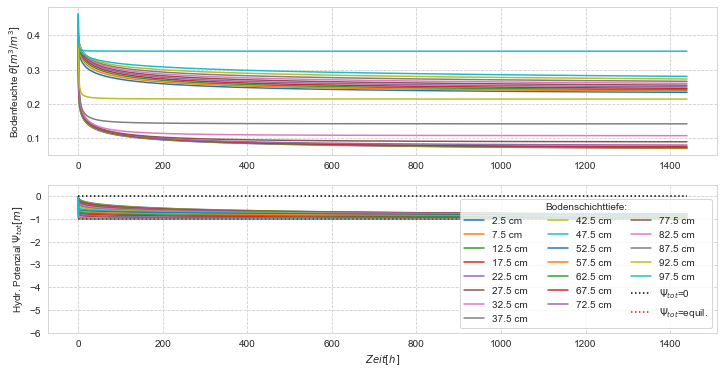

In [10]:
# Plot der Ergebnisse
figsize(12,6)
subplot(211)
plot(np.arange(len(moisture))*tstep,moisture)
ylabel(r'Bodenfeuchte $\theta [m^3/m^3]$')
#xlabel(r'$time [h]$')


subplot(212)
for i in np.arange(np.shape(potential)[1]):
    #plot(np.arange(len(potential))*tstep,np.array(potential)[:,i],label=str(i*10+5)+' cm')
    plot(np.arange(len(potential))*tstep,np.array(potential)[:,i],label=str(i*5+2.5)+' cm')
plot([0,len(moisture)*tstep],[0,0],'k:',label=r'$\Psi_{tot}$=0')
plot([0,len(moisture)*tstep],[gw.potential,gw.potential],'r:',label=r'$\Psi_{tot}$=equil.')
ylabel(r'Hydr. Potenzial $\Psi_{tot} [m]$')
xlabel(r'$Zeit [h]$')
ylim([-6,0.5])
legend(loc=4,ncol=3,title='Bodenschichttiefe:')
#savefig('dyn_col.pdf',bbox_inches='tight')

(0.0, 0.6)

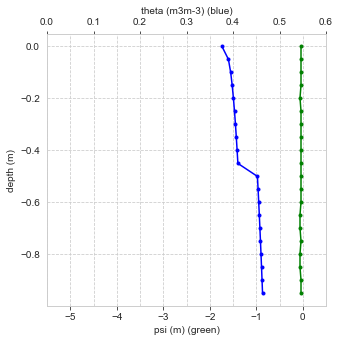

In [11]:
# create a figure and axes
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(1,1,1)
ti = np.arange(len(moisture)*tstep).astype(str)

line1, = ax1.plot(potential[0],np.arange(20)*-0.05,'g.-')
ax1.set_xlabel('psi (m) (green)')
ax1.set_ylabel('depth (m)')
ax1.set_xlim(-5.5,+0.5)
ax1a = ax1.twiny()
line2, = ax1a.plot(moisture[0],np.arange(20)*-0.05,'b.-')
ax1a.set_xlabel('theta (m3m-3) (blue)')
ax1a.set_xlim(0.0,0.6)
#text1 = ax1.text(-1,-0.05,ti[0])


In [12]:
def drawframe(t):     
    line1.set_data(potential[t*20],np.arange(20)*-0.05)
    line2.set_data(moisture[t*20],np.arange(20)*-0.05)
    return (line1,line2)

In [13]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=100, blit=True)



In [14]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [21]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('SCL_S.mp4', writer=writer)

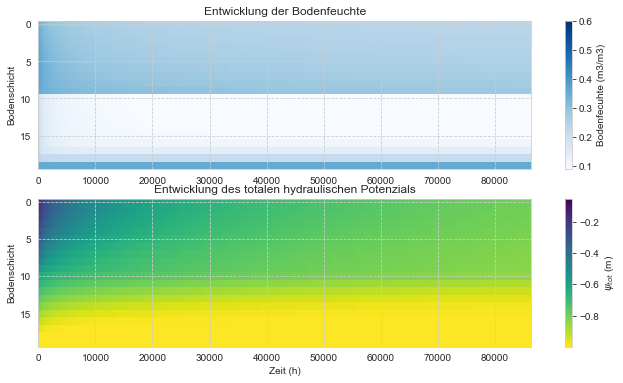

In [22]:
figsize(12,6)
subplot(211)
imshow(np.array(moisture).T,aspect=1300,cmap='Blues',vmin=0.09,vmax=0.6)
#xticks(np.arange(11)*(48/tstep),np.arange(11)*48)
#xlabel('Zeit (h)')
#xticklabels([])
ylabel('Bodenschicht')
colorbar(label='Bodenfecuhte (m3/m3)')
title('Entwicklung der Bodenfeuchte')

subplot(212)
imshow(np.array(potential).T,aspect=1300,cmap='viridis_r')
#xticks(np.arange(11)*(48/tstep),np.arange(11)*48)
xlabel('Zeit (h)')
ylabel('Bodenschicht')
colorbar(label='$\psi_{tot}$ (m)')
title('Entwicklung des totalen hydraulischen Potenzials')
savefig('dyn_col_im.pdf',bbox_inches='tight')

Text(0.5, 1.0, 'Entwicklung der Bodenfeuchte')

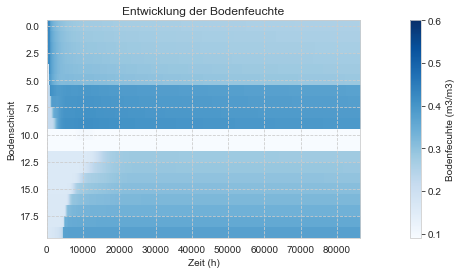

In [31]:
figsize(18,4)
imshow(np.array(moisture).T,aspect=3000,cmap='Blues',vmin=0.09,vmax=0.6)
#xticks(np.arange(11)*(48/tstep),np.arange(11)*48)
xlabel('Zeit (h)')
ylabel('Bodenschicht')
colorbar(label='Bodenfecuhte (m3/m3)')
title('Entwicklung der Bodenfeuchte')

Text(0.5, 1.0, 'Entwicklung des totalen hydraulischen Potenzials')

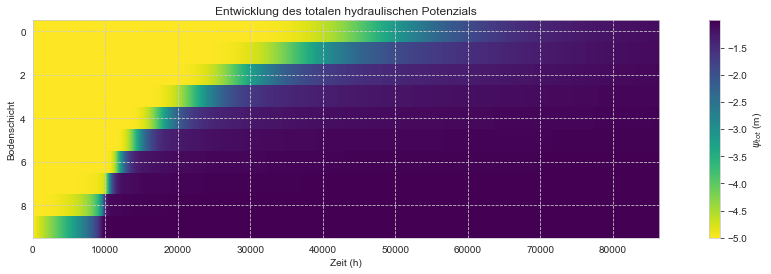

In [12]:
figsize(18,4)
imshow(np.array(potential).T,aspect=3000,cmap='viridis_r')
#xticks(np.arange(11)*(48/tstep),np.arange(11)*48)
xlabel('Zeit (h)')
ylabel('Bodenschicht')
colorbar(label='$\psi_{tot}$ (m)')
title('Entwicklung des totalen hydraulischen Potenzials')

Nun können Sie mit den Randbedingungen, den Anfangsbedingungen und den Parametern etwas spielen. Versuchen Sie in einem ersten Schritt doch einmal zu sehen, was passiert, wenn der Boden zu Beginn trockener oder feuchter ist...

Ändern Sie dazu die entsprechenden Definitionen und lassen Sie den Kernel am besten neu starten und alles durchlaufen. Wenn Sie nur einzelne Zellen des Skripts neu laufen lassen, kann es passieren, dass entweder der Anfangszustand nicht neu gesetzt wird oder die Definitionen der Bodenschichten nicht ü